# FastModel

In [ ]:
# tmp code area
snapshot_download(sd_id, cache_dir = ckpt_base_pth, revision='v1.0.0') 

## Import

In [ ]:
import os
from os import path

import pyarrow as pa
import torch
from datasets import load_dataset
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import LazyConfig, instantiate
from diffusers import AutoPipelineForText2Image
from huggingface_hub import hf_hub_download
from modelscope import AutoTokenizer
from modelscope.hub.snapshot_download import snapshot_download
from modelscope.models import Model
from modelscope.msdatasets import MsDataset
from modelscope.pipelines import pipeline
from modelscope.preprocessors import Preprocessor
from modelscope.utils.constant import Tasks
from transformers import AutoModel, LlamaModel

## prepare datasource

取数据集, 取[huggingface](https://huggingface.co/datasets/phiyodr/coco2017)或者[modelScope](https://www.modelscope.cn/datasets/zacbi2023/coco2017_caption/summary)

### huggingface

In [ ]:
hf_dataset = load_dataset("phiyodr/coco2017")

# 如果单独取 train 或者 validation
hf_ds_train = load_dataset("phiyodr/coco2017", split="train")
hf_ds_validation = load_dataset("phiyodr/coco2017", split="validation")

### modelscope

modelscope 的优点就是非常快, 毕竟是墙内的, 缺点是某些数据集不全，就算调用官方的api，并指定源为huggingface，也可能产生报错。
这里的解决方案是先把huggingface的repo download下来，然后传到modelscope里，对于parquet类型的数据文件，非常友好.

In [ ]:
ms_ds_train = MsDataset.load('zacbi2023/coco2017_caption', subset_name='default', split='train')
ms_ds_validation = MsDataset.load('zacbi2023/coco2017_caption', subset_name='default', split='validation')

In [ ]:
# 拉取到本地
base_url = r'/mnt/workspace'
ckpt_base_pth = path.join(base_url, 'model')
llama_id = r'modelscope/Llama-2-7b-ms'
sd_id = r'AI-ModelScope/stable-diffusion-2-1'
llama_path = os.path.join(ckpt_base_pth, llama_id)
sd_path = os.path.join(ckpt_base_pth, sd_id)

## Remap data

目前我们需要的仅仅是生成horse, dog, cat类型的图像, 用简单分词然后建立新的数据库

In [ ]:
if not os.path.exists(llama_path):
    snapshot_download(llama_id, cache_dir = ckpt_base_pth)
if not os.path.exists(sd_path):
    snapshot_download(sd_id, cache_dir = ckpt_base_pth) 

In [ ]:
# bert 原始一点, 不会特别多的在 token 上做操作,比如增加'_' prefix or suffix
bert_tokenizer = AutoTokenizer.from_pretrained("sdfdsfe/bert-base-uncased")

categories = set(['horse', 'dog', 'cat'])
select_ds_cols = ['image_id', 'captions']
def build_new_ds(dataset):
    """
        构建新数据集,包括原来的图片 id 和 caption,caption 取 captions 中最长的,另外增加 tag,标明是怎么样的类型
    """
    new_dataset = dataset.select_columns(select_ds_cols)
    new_dataset = new_dataset.add_column(name = 'caption', column = [captions[max(range(len(captions)), key=lambda i: len(captions[i]))]  for captions in  dataset['captions']])
    # 暂时不用存储 llama 的输出
    # new_dataset = new_dataset.add_column(name = 'last_hidden_state', column = [torch.zeros(1).numpy().tolist() for i in range(len(new_dataset))])
    new_dataset = new_dataset.remove_columns(['captions'])

    def add_tags(caption):
        tags = []
        tokennized_caption = set(bert_tokenizer.tokenize(caption))
        for category in categories:
            if category in tokennized_caption:
                tags.append(category)
        return tags
    new_dataset = new_dataset.add_column(name = 'tags', column = [add_tags(caption) for caption in new_dataset['caption']])
    new_dataset = new_dataset.filter(lambda x: len(x['tags']) > 0)

    return new_dataset

ds_train = build_new_ds(ms_ds_train)
ds_train.features, ds_train[0]

## accelerate infer

In [ ]:
device = 'gpu' if torch.cuda.is_available() else 'cpu'
# device_map = '0'
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
# from_pretrained_dict = {'device_map': device_map, 'torch_dtype' : torch_dtype, 'revision': 'v1.0.1'}
from_pretrained_dict = {'torch_dtype' : torch_dtype,  'variant': 'fp16'}

def prompt_tensors_to_cuda(token_tensors):
    for k, v in token_tensors.items():
        token_tensors[k] = v.to('cuda')
    return token_tensors

# LLama

## 加载 model 和 tokenizer

In [ ]:
# llama
# llama_model = LlamaModel.from_pretrained(llama_path, **from_pretrained_dict)
llama_tokenizer = AutoTokenizer.from_pretrained(llama_path)

In [ ]:
# sd
# stable_diffusion_model = Model.from_pretrained(sd_path, **from_pretrained_dict)

prompt = ds_train['caption'][0]
token_tensors = llama_tokenizer(prompt, return_tensors='pt')
llama_outputs = llama_model(**prompt_tensors_to_cuda(token_tensors))

In [ ]:
llama_outputs.last_hidden_state.shape

In [10]:
# sd pipeline
sd_pipeline = AutoPipelineForText2Image.from_pretrained(sd_path, **from_pretrained_dict).to('cuda')

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/opt/conda/envs/eva/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [ ]:
prompt = ds_train['caption'][0]
llama_tokenizer = AutoTokenizer.from_pretrained(llama_path)
with torch.no_grad():
    token_tensors = llama_tokenizer(prompt, return_tensors='pt')
    llama_outputs = llama_model(**prompt_tensors_to_cuda(token_tensors))
    prompt_embeds = outputs.last_hidden_state
    sd_outputs = sd_pipeline(prompt_embeds=prompt_embeds)
    sd_outputs.image[0]

# Stable diffusion

In [38]:
# prompt = ds_train['caption'][0]
prompt = 'dog'
sd_output = sd_pipeline(prompt)
images = sd_output.images
image = images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

In [35]:
ds_train['caption'][0]

'A girl smiles as she holds a cat and wears a brightly colored skirt.'

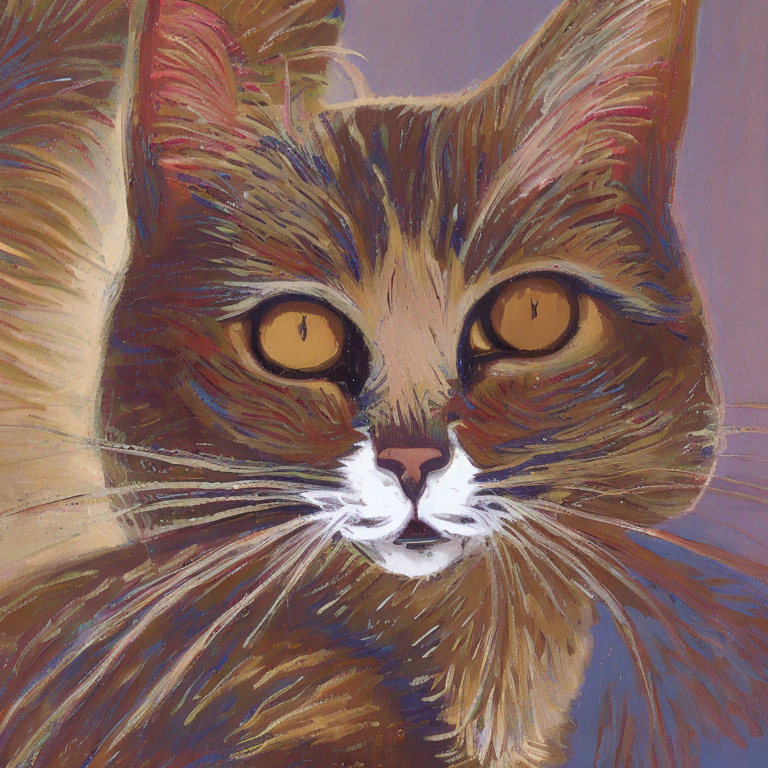

In [37]:
image

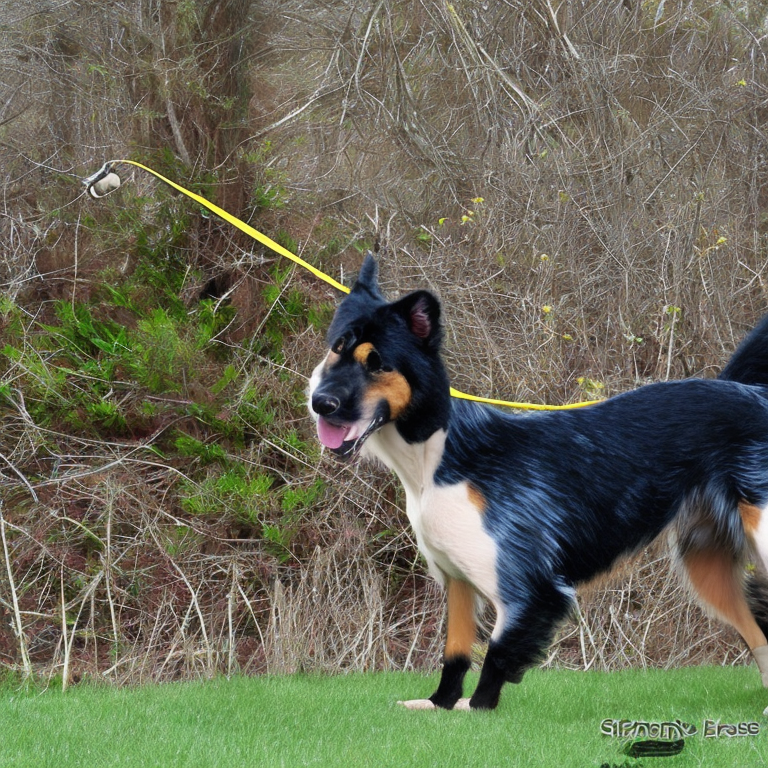

In [39]:
image